In [7]:
# We will download the pre-trained weights for model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-17 16:43:41--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  32.0MB/s    in 2.6s    

2024-06-17 16:43:44 (32.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Here we will store our local weights
local_weight_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model
# set the input shape and remove the dense layer

pre_trained_model = InceptionV3(
    include_top = False,
    input_shape = (150, 150, 3),
    weights = None
)

# Load our pre trained weights that we downloaded
pre_trained_model.load_weights(local_weight_file)

# Freeze the weights of layers
for layer in pre_trained_model.layers:
  layer.trainable = False

In [9]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

In [10]:
# Choose mixed7 as the last layer of base model baecuse it result of multipel 7*7 convolutional so it has more information than the last layer
# of base model which are 3*3 convolutionals

last_layer = pre_trained_model.get_layer('mixed7')
print("Output shape of last layer", last_layer.output_shape)
last_output = last_layer.output

Output shape of last layer (None, 7, 7, 768)


In [14]:
# Add dense layers for our own classifier model

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# We used to write tf.keras.layers.Flatten() but here in this case we have alredy imported layers from tf.keras so we will use
x = layers.Flatten()(last_output) # our last_output variable from above will be input of flatten layer bcz we have to flatten it to feed to nn.

x = layers.Dense(1024, activation = 'relu')(x) #Do not use commas here
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

# For final model using pre_trained_model

model = Model(pre_trained_model.input, x)


In [15]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = RMSprop(learning_rate = 0.0001),
    metrics = ['accuracy']
)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalization_94[0

In [17]:
# Now data downloading
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-06-17 17:12:45--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  29.3MB/s    in 2.2s    

2024-06-17 17:12:48 (29.3 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [19]:
import zipfile

zip_ref = zipfile.ZipFile('./cats_and_dogs_filtered.zip', 'r')
zip_ref.extractall("tmp")
zip_ref.close()

In [28]:
import os

base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')


In [25]:
print("No of training images:", len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))

print("\nNo of validation images:", len(os.listdir(valid_cats_dir)) + len(os.listdir(valid_dogs_dir)))

No of training images: 2000

No of validation images: 1000


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 20,
    verbose = 1,
    validation_data = valid_generator,
    validation_steps = 100
)

Epoch 1/20
100/100 [==============================] - 20s 202ms/step - loss: 0.3182 - accuracy: 0.8720 - val_loss: 0.1059 - val_accuracy: 0.9580
Epoch 2/20
100/100 [==============================] - 18s 177ms/step - loss: 0.2107 - accuracy: 0.9200 - val_loss: 0.0909 - val_accuracy: 0.9680
Epoch 3/20
100/100 [==============================] - 16s 162ms/step - loss: 0.1732 - accuracy: 0.9310 - val_loss: 0.0786 - val_accuracy: 0.9650
Epoch 4/20
100/100 [==============================] - 20s 202ms/step - loss: 0.1648 - accuracy: 0.9355 - val_loss: 0.1246 - val_accuracy: 0.9460
Epoch 5/20
100/100 [==============================] - 17s 166ms/step - loss: 0.1544 - accuracy: 0.9385 - val_loss: 0.0787 - val_accuracy: 0.9730
Epoch 6/20
100/100 [==============================] - 17s 167ms/step - loss: 0.1341 - accuracy: 0.9470 - val_loss: 0.0914 - val_accuracy: 0.9650
Epoch 7/20
100/100 [==============================] - 16s 161ms/step - loss: 0.1302 - accuracy: 0.9460 - val_loss: 0.0837 - val_ac

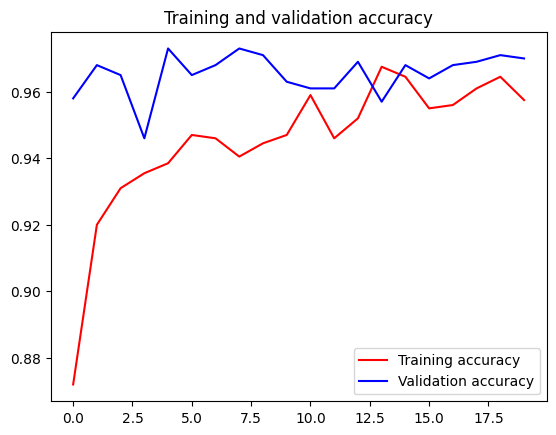

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()